In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
# Load data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables]#.groupby(['age', 'uuid', 'mouse']).mean()

# get age in weeks
weeks = (df.index.get_level_values('age') * 7) // 30


monthly_first = df.groupby(['mouse', weeks], observed=True).first()

# If 'age' is the original age in weeks and you want to keep it
# monthly_first['age'] = monthly_first['age_months'] * 4

# Set the index back to age (in weeks) and mouse
# monthly_first.set_index(['age', 'mouse'], inplace=True)

df_male= monthly_first.copy()

In [6]:
# Load data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables]#.groupby(['age', 'uuid', 'mouse']).mean()

# get age in weeks
weeks = (df.index.get_level_values('age') * 7) // 30


monthly_first = df.groupby(['mouse', weeks], observed=True).first()

# If 'age' is the original age in weeks and you want to keep it
# monthly_first['age'] = monthly_first['age_months'] * 4

# Set the index back to age (in weeks) and mouse
# monthly_first.set_index(['age', 'mouse'], inplace=True)

df_female= monthly_first.copy()

In [7]:
df_female.index.get_level_values('age')

Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0,
       ...
        2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0],
      dtype='float32', name='age', length=240)

In [8]:
# avarage per age or session
m_df=df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# avarage per age or session
f_df=df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [9]:
dist=[]
data=m_df.copy()
for m, _df in data.groupby('mouse'):
    smoothed_usage = _df.rolling(
        1, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    dist.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
    
boot_df = pd.DataFrame(dist).T.reset_index()
boot_df = boot_df.melt(id_vars=["age",'mouse'])
boot_df_m=boot_df.copy()

In [10]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

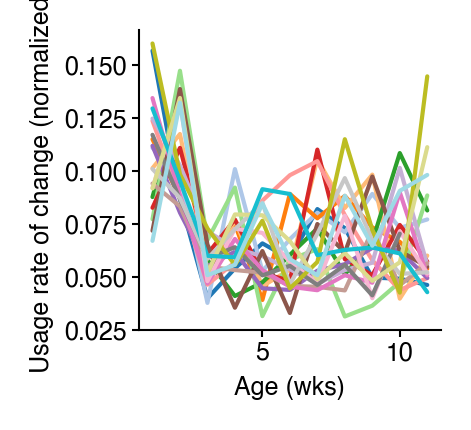

In [11]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    hue='mouse',
    palette='tab20',
    legend=False,
)

ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", 
       #xticks = [0,10,20,30,40],
      )
sns.despine()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'aging_rate_indv_lines_first_month_diff_norm.pdf', bbox_inches='tight')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


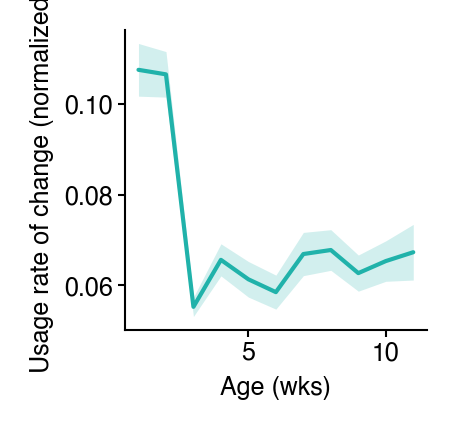

In [13]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    legend=False,
    errorbar=("se"),
    err_kws=dict(lw=0),
    color='#20B2AA',
)
#plt.ylim(0.2,1)
ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", 
       #xticks = [0,10,20,30,40],
      )
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'aging_rate_indv_avg_first_month_diff_norm.pdf', bbox_inches='tight')

In [15]:
dist=[]
data=f_df.copy()
for m, _df in data.groupby('mouse'):
    smoothed_usage = _df.rolling(
        1, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    dist.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
    
boot_df = pd.DataFrame(dist).T.reset_index()
boot_df = boot_df.melt(id_vars=["age",'mouse'])
boot_df_f=boot_df.copy()

In [16]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

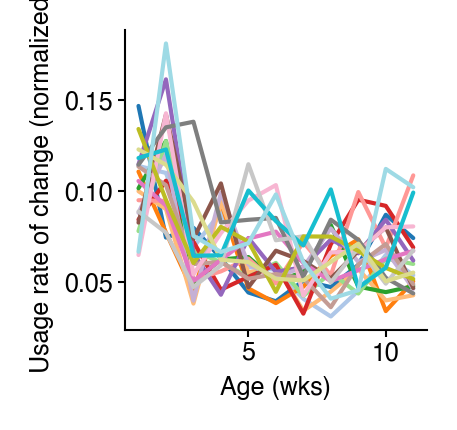

In [17]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_f,
    x="age",
    y="value",
    hue='mouse',
    palette='tab20',
    legend=False,
)

ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)",
       #xticks = [0,10,20,30,40],
      )
sns.despine()

In [18]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'aging_rate_indv_lines_first_month_female_diff_notnorm.pdf', bbox_inches='tight')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


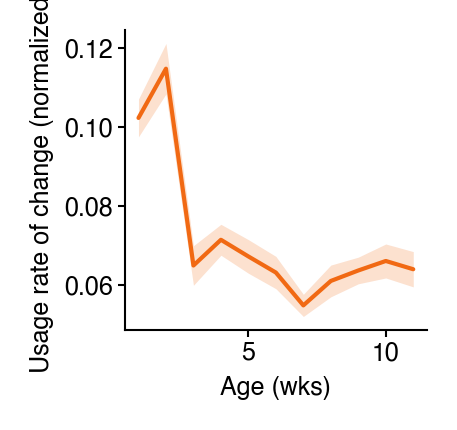

In [19]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_f,
    x="age",
    y="value",
    legend=False,
    errorbar=("se"),
    err_kws=dict(lw=0),
    color='#f16913',
)
#plt.ylim(0.2,1)
ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)",
       #xticks = [0,10,20,30,40],
      )
sns.despine()

In [20]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'aging_rate_indv_avg_first_month_female_diff_notnorm.pdf', bbox_inches='tight')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

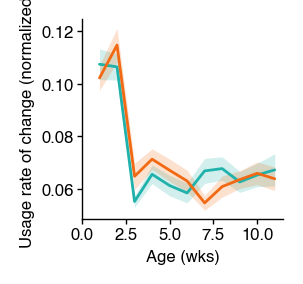

In [21]:
format_plots()
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)

ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    legend=False,
    errorbar=("se"),
    err_kws=dict(lw=0),
    color='#20B2AA',
)

ax = sns.lineplot(
    data=boot_df_f,
    x="age",
    y="value",
    legend=False,
    errorbar=("se"),
    err_kws=dict(lw=0),
    color='#f16913',
)

ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", 
       xticks = [0,2.5,5,7.5,10],
      )
sns.despine()

In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'aging_rate_indv_avg_mean_month_fvm_diff_notnorm.pdf', bbox_inches='tight')